In [2]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy import optimize
from scipy import stats

#### Data prep.

In [3]:
KP10_flux_df = pd.read_table('KPA22_001-365.FLX',delimiter=r"\s+")


In [4]:
KP10_flux_df['date'] = pd.to_datetime(KP10_flux_df.date,format='%Y-%m-%d')

In [5]:
#filtering out NANs and low quality flux data
def flux_qc_10(flux_df):
    #NAN filter
    H_f1 = flux_df['H_10m']!=-999
    #qc flag
    H_f2 = flux_df['qc_H'] < 1

    LE_f1 = flux_df['LE_10m']!=-999
    #qc flag
    LE_f2 = flux_df['qc_LE'] < 1
    
    return(flux_df.loc[H_f1 & H_f2 & LE_f1 & LE_f2])


In [6]:
KPA_flux_df_22 = flux_qc_10(KP10_flux_df).copy()


In [7]:
KPA_flux_df_22['date_time'] = pd.to_datetime((KPA_flux_df_22.date.astype(str) + ' ' + KPA_flux_df_22['time(MST)']))
KPA_flux_df_22 = KPA_flux_df_22.set_index('date_time')

In [8]:
#select fluxes for months of june to august

H_month1 = KPA_flux_df_22.index.month >= 6 
H_month2 = KPA_flux_df_22.index.month <= 10 

H_ustar = KPA_flux_df_22['u*_10m'] >= 0.1

H_small = np.abs(KPA_flux_df_22['H_10m']) >= 10


In [9]:
KPA_flux_df_22_subset =  KPA_flux_df_22.loc[H_month1 & H_month2 & H_ustar & H_small].sort_index().copy()

In [10]:
kp_met_df = pd.read_csv('KP22_001-365.MET30X',delimiter=r"\s+")


In [11]:

kp_met_df['date_time'] = pd.to_datetime((kp_met_df.date.astype(str) + ' ' + kp_met_df['time(MST)']))
kp_met_df = kp_met_df.set_index('date_time')

In [12]:

kp_met_df['date_time'] = pd.to_datetime((kp_met_df.date.astype(str) + ' ' + kp_met_df['time(MST)']))
kp_met_df = kp_met_df.set_index('date_time')

In [13]:
column_names = kp_met_df.columns.to_list()
print(column_names)

['date', 'time(MST)', 'DecDay', 'wsp_3m', 'wsp_5m', 'wsp_10m', 'dir_3m', 'dir_5m', 'dir_10m', 'stheta_3m', 'stheta_5m', 'stheta_10m', 'Pressure_Avg', 'RH_Avg', 'Tair1_3m', 'Tair2_3m', 'Tair1_5m', 'Tair2_5m', 'Tair1_10m', 'Tair2_10m', 'SurfT1_C', 'SurfT2_C', 'SurfT3_C', 'SurfTave_C', 'del_Ts', 'del_ws', 'emm', 'T3m_T5m', 'Ts_Ta', 'NetBodyT', 'Rg_in_avg', 'Rg_out_avg', 'Lw_in_avg', 'Lw_out_avg', 'ghflx_a', 'ghflx_b', 'ghflx_c', 'stor_a', 'stor_b', 'stor_c', 'SoilT2a_Avg', 'SoilT5a_Avg', 'SoilT10a_Avg', 'SoilT20a_Avg', 'SoilT50a_Avg', 'SoilT2b_Avg', 'SoilT5b_Avg', 'SoilT10b_Avg', 'SoilT20b_Avg', 'SoilT50b_Avg', 'SoilT2c_Avg', 'SoilT5c_Avg', 'SoilT10c_Avg', 'SoilT20c_Avg', 'SoilT50c_Avg']


In [14]:
#i need a column for delta_T (let's say surf - 10m)
kp_met_df['Tair_10m_mean'] = (kp_met_df['Tair1_10m'] + kp_met_df['Tair2_10m'])/2
kp_met_df['SurfT_C_mean'] = (kp_met_df['SurfT1_C'] + kp_met_df['SurfT2_C'] + + kp_met_df['SurfT3_C'])/3

#kp_met_df['delta_T']  =  kp_met_df['Tair_10m_mean'] - kp_met_df['SurfT_C_mean']

In [15]:
#now subset this data for the months and for daytime (net rad > 25 w/m2)
#day_f1 = kp_met_df.Rg_in_avg >= 25

month_f1 = kp_met_df.index.month >= 6 
month_f2 = kp_met_df.index.month <= 10 

#delta_T_f = kp_met_df.delta_T > 0.5
#commenting out the delta_T flag. 20240905 paleri
kp_met_df_subset =  kp_met_df.loc[month_f1 & month_f2].sort_index().copy()

In [16]:
#pandas dataframe with both 30 min flux and metdata, final dataframe we can work with
KPA_flux_df_22_met = pd.merge(KPA_flux_df_22_subset,kp_met_df_subset, on='date_time')

#### Calculate modeled fluxes

In [17]:
KPA_flux_df_22_met.columns

Index(['date_x', 'time(MST)_x', 'DecDay_x', 'H_10m', 'qc_H', 'LE_10m', 'qc_LE',
       'co2_flx_10m', 'co2_mix_ratio', 'Ts_10m', 'Tair_10m', 'pressure',
       'density', 'e_10m', 'es_10m', 'RH', 'Tdew', 'u_unrot_10m',
       'v_unrot_10m', 'w_unrot_10m', 'u_rot_10m', 'wind_speed',
       'max_wind_speed', 'wind_dir', 'u*_10m', 'TKE_10m', 'u_var_10m',
       'v_var_10m', 'w_var_10m', 'Ts_var_10m', 'co2_var_10m', 'h2o_var_10m',
       'date_y', 'time(MST)_y', 'DecDay_y', 'wsp_3m', 'wsp_5m', 'wsp_10m',
       'dir_3m', 'dir_5m', 'dir_10m', 'stheta_3m', 'stheta_5m', 'stheta_10m',
       'Pressure_Avg', 'RH_Avg', 'Tair1_3m', 'Tair2_3m', 'Tair1_5m',
       'Tair2_5m', 'Tair1_10m', 'Tair2_10m', 'SurfT1_C', 'SurfT2_C',
       'SurfT3_C', 'SurfTave_C', 'del_Ts', 'del_ws', 'emm', 'T3m_T5m', 'Ts_Ta',
       'NetBodyT', 'Rg_in_avg', 'Rg_out_avg', 'Lw_in_avg', 'Lw_out_avg',
       'ghflx_a', 'ghflx_b', 'ghflx_c', 'stor_a', 'stor_b', 'stor_c',
       'SoilT2a_Avg', 'SoilT5a_Avg', 'SoilT10a_Avg', 'S

In [18]:
KPA_flux_df_22_met['sig_w'] = KPA_flux_df_22_met['w_var_10m']**0.5
KPA_flux_df_22_met['sig_u'] = KPA_flux_df_22_met['u_var_10m']**0.5
KPA_flux_df_22_met['sig_v'] = KPA_flux_df_22_met['v_var_10m']**0.5
KPA_flux_df_22_met['Tbulk'] = KPA_flux_df_22_met['Tair_10m_mean']+273.18
#df_met['ustar'] = (-df_met['uw'])**0.5#why the negative sign?
#we have ustar calculated by smartflux at KP
KPA_flux_df_22_met['Ri_bulk'] = (KPA_flux_df_22_met['Tair_10m_mean']-KPA_flux_df_22_met['SurfT_C_mean'])*9.8*10.0/(KPA_flux_df_22_met['Tbulk']*KPA_flux_df_22_met['wsp_10m']**2) #



In [19]:
#turbulent intensities
# compute the turbulence intensities using mean wind at 10 m
KPA_flux_df_22_met['itw'] = KPA_flux_df_22_met['sig_w']/KPA_flux_df_22_met['wsp_10m']     
KPA_flux_df_22_met['itu'] = KPA_flux_df_22_met['sig_u']/KPA_flux_df_22_met['wsp_10m']
KPA_flux_df_22_met['itv'] = KPA_flux_df_22_met['sig_v']/KPA_flux_df_22_met['wsp_10m']
KPA_flux_df_22_met['itustar'] = KPA_flux_df_22_met['u*_10m']/KPA_flux_df_22_met['wsp_10m']



In [21]:
#H and LE calculated from bulk stats
#df_met['alt_LE'] = (df_met['qs']-df_met['qa'])*df_met['density']*df_met['sig_w']*df_met['Lat']*0.06
#df_met['alt_H'] = -(df_met['Tair10']-df_met['Ts'])*df_met['sig_w']*df_met['density']*df_met['cp']*.06


In [22]:
#subset
fx1 = KPA_flux_df_22_met[(KPA_flux_df_22_met['wsp_10m'] > 2) & (KPA_flux_df_22_met['u*_10m'] > 0)]


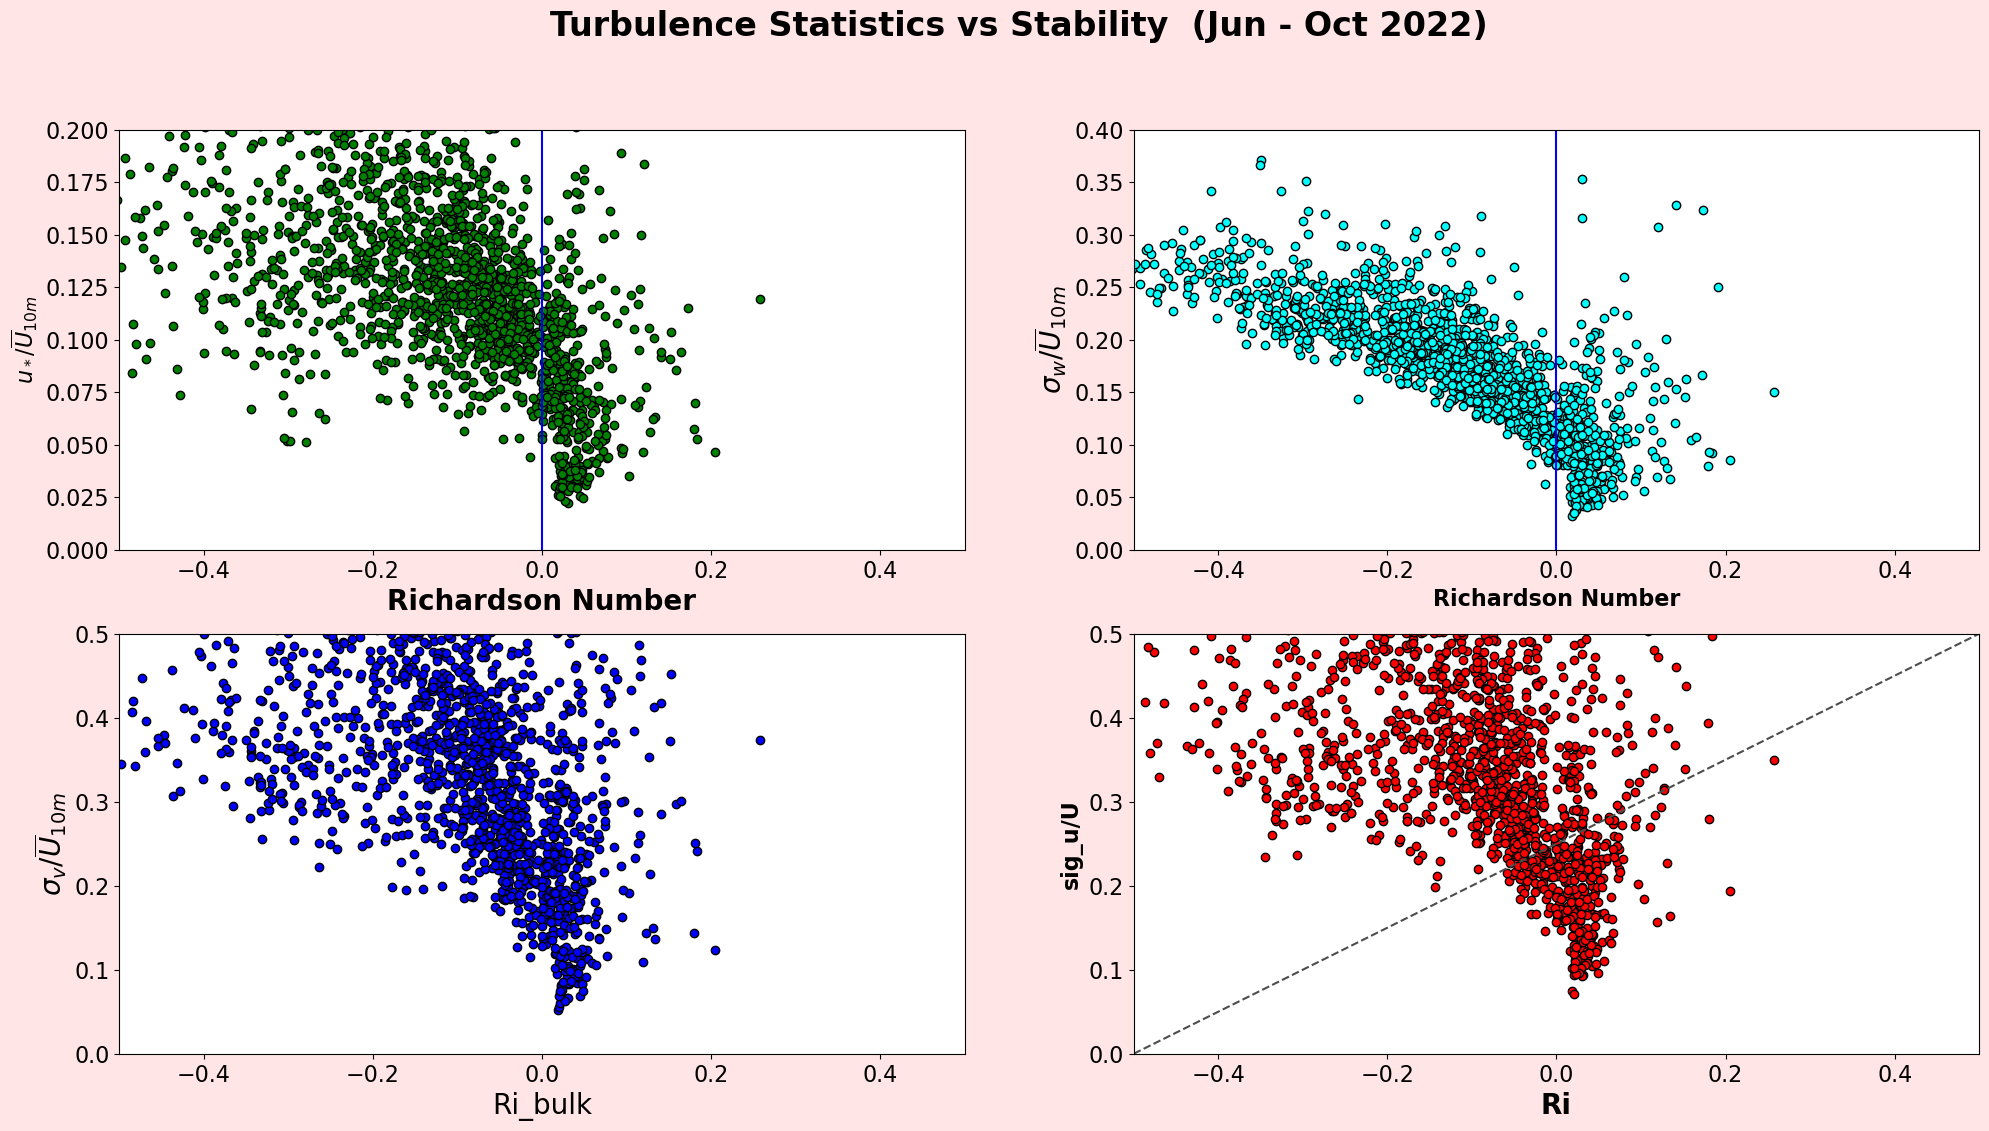

In [23]:
fig = plt.figure(facecolor=(1,0,0,0.1),figsize=(24,12))
ax = fig.add_subplot(2,2,4)
plt.axis([-0.5,0.5,0,0.5])
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel('Ri',fontsize=20,fontweight = "bold")
plt.ylabel('sig_u/U',fontsize=16,fontweight = "bold")
plt.scatter(fx1['Ri_bulk'],fx1['itu'],color = 'red', edgecolor = 'black')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.suptitle('Turbulence Statistics vs Stability  (Jun - Oct 2022)', fontsize=24, fontweight = "bold")
#Y = fx1['alt_H']
#X = fx1['H_3m']
#model = sm.OLS(Y, X).fit()
#predictions = model.predict(X) # make the predictions by the model
#print(predictions) 
# Print out the statistics
#print(model.summary())
#
plt.subplot(222)
plt.axis([-0.5,0.5,0,0.4])
plt.ylabel(r'$\sigma_w/\overline{U}_{10m}$',fontsize=20,fontweight = "bold")
plt.xlabel('Richardson Number',fontsize=16,fontweight = "bold")
plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itw'],color='cyan', edgecolor = 'black')
#
plt.subplot(223)
plt.axis([-0.5,0.5,0,0.5])
plt.ylabel(r'$\sigma_v/\overline{U}_{10m}$',fontsize=20,fontweight = "bold")
plt.xlabel('Ri_bulk',fontsize=20)
#plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itv'],color='blue', edgecolor = 'black')
#
plt.subplot(221)
plt.axis([-0.5,0.5,0,0.2])
plt.ylabel(r'$u_*/\overline{U}_{10m}$',fontsize = 16,fontweight="bold")
plt.xlabel('Richardson Number',fontsize=20,fontweight = "bold")
plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itustar'],color='green', edgecolor = 'black')
#

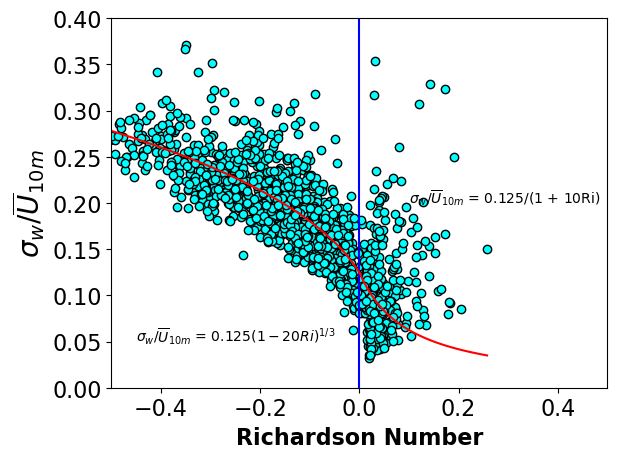

In [42]:
x_values_negative = np.linspace(fx1['Ri_bulk'].min(),0)

x_values_positive = np.linspace(0,fx1['Ri_bulk'].max())

unstable_y = 0.125*((1-20*x_values_negative)**(1/3))
stable_y = 0.125/((1+10*x_values_positive))

plt.figure()
plt.axis([-.5,0.5,0,0.4])
plt.ylabel(r'$\sigma_w/\overline{U}_{10m}$',fontsize=20,fontweight = "bold")
plt.xlabel('Richardson Number',fontsize=16,fontweight = "bold")
plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itw'],color='cyan', edgecolor = 'black')
plt.text(-0.45,0.05,r'$\sigma_w/\overline{U}_{10m}$ = $0.125(1 - 20Ri)^{1/3}$')
plt.text(0.1,0.2,r'$\sigma_w/\overline{U}_{10m}$ = 0.125/(1 + 10Ri)')
plt.plot(x_values_negative,unstable_y,'r')
plt.plot(x_values_positive,stable_y,'r')
#ax1.vlines(x=0,ymin=0,ymax=1.4,colors='r')



##### first do a simple model, with measured sigma_w and delta_T


In [26]:
fx1['H_10m_param'] =((fx1['sig_w'])*(fx1['Tair_10m_mean'] - fx1['SurfT_C_mean']))*fx1['density']*1009

/tmp/ipykernel_8790/1777424286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fx1['H_10m_param'] =((fx1['sig_w'])*(fx1['Tair_10m_mean'] - fx1['SurfT_C_mean']))*fx1['density']*1009


In [35]:

def linear_regress_scipy(df):
    y = df['H_10m']
    x = df['H_10m_param']
    # y = a + b * x
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return gradient, intercept, r_value, p_value, std_err



In [39]:
sample_df['H_10m']

date_time
2022-08-28 12:00:00    190.8
2022-07-16 19:30:00    -72.0
2022-09-06 12:30:00    317.2
2022-06-16 11:00:00    248.4
2022-06-28 12:30:00    100.7
                       ...  
2022-07-08 10:00:00    131.5
2022-06-16 12:30:00    252.1
2022-08-31 10:30:00    182.7
2022-09-08 12:30:00    183.7
2022-06-23 13:30:00     61.6
Name: H_10m, Length: 887, dtype: float64

,date_x,time(MST)_x,DecDay_x,H_10m,qc_H,LE_10m,qc_LE,co2_flx_10m,co2_mix_ratio,Ts_10m,...,sig_u,sig_v,Tbulk,Ri_bulk,itw,itu,itv,itustar,H_10m_param,H_10m_modeled
date_time,,,,,,,,,,,,,,,,,,,,,
2022-06-01 08:30:00,2022-06-01,08:30:00,152.354,133.9,0,155.5,0,-10.438,387.8,281.12,...,1.241410,1.199417,282.285,-0.345677,0.214012,0.558942,0.540034,0.158487,-2103.577233,109.603439
2022-06-01 09:30:00,2022-06-01,09:30:00,152.396,226.3,0,215.8,0,-12.231,386.7,282.49,...,1.112803,1.369785,283.610,-0.300704,0.225097,0.407173,0.501202,0.151482,-3590.910013,177.478995
2022-06-01 10:00:00,2022-06-01,10:00:00,152.417,138.5,0,180.1,0,-8.952,385.6,282.97,...,1.347705,1.865808,284.340,-0.633606,0.284897,0.664877,0.920478,0.184016,-3903.865484,191.760955
2022-06-01 11:00:00,2022-06-01,11:00:00,152.458,235.3,0,329.7,0,-15.689,386.6,284.23,...,2.274937,1.923364,285.290,-0.150100,0.204814,0.555948,0.470030,0.113148,-5469.555633,263.212409
2022-06-01 12:00:00,2022-06-01,12:00:00,152.500,220.7,0,291.6,0,-12.818,386.9,284.69,...,2.720647,1.879737,285.840,-0.125093,0.160838,0.544674,0.376324,0.117317,-6515.937188,310.964822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-30 18:00:00,2022-10-30,18:00:00,303.750,-77.9,0,26.9,0,3.068,382.9,275.80,...,1.107199,1.164822,276.045,0.041613,0.088960,0.210214,0.221155,0.087906,1405.077279,-50.516663
2022-10-30 19:00:00,2022-10-30,19:00:00,303.792,-72.4,0,15.0,0,2.955,383.6,274.59,...,0.774584,1.186486,274.750,0.045285,0.090575,0.152237,0.233193,0.059945,1402.963317,-50.420190
2022-10-31 14:30:00,2022-10-31,14:30:00,304.604,13.6,0,53.5,0,0.500,384.0,279.90,...,0.798593,1.013144,281.170,0.039321,0.169090,0.361681,0.458851,0.177989,185.021043,5.161526


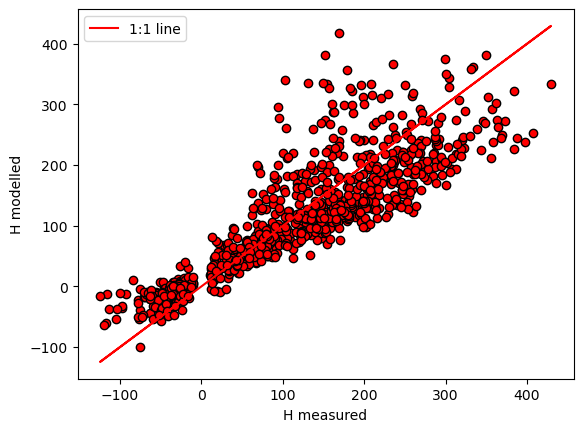

In [ ]:
    
length_of_df = fx1.shape[0]


sample_df = fx1.sample(n=int(length_of_df/2),random_state=42)

#try linear regression and get constants for this df:
gradient, intercept, r_value, p_value, std_err = linear_regress_scipy(sample_df)

y = sample_df['H_10m']
x = sample_df['H_10m_param']

#create a data frame for the testing data:

#https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
#should just call sample_df_rest as fx2

sample_df_rest = fx1.loc[~fx1.index.isin(sample_df.index)].sort_index()
sample_df_rest['H_10m_modeled'] = intercept + gradient*sample_df_rest['H_10m_param']

#final plot, checking in with the testing data
y = sample_df_rest['H_10m_modeled']
x = sample_df_rest['H_10m']

fig, ax = plt.subplots()

plt.scatter(x, y, color='red',edgecolor = 'black')
plt.plot(x, 1*x, 'r', label='1:1 line')
ax.set_xlabel('H measured')
ax.set_ylabel('H modelled')
#plt.plot(sample_df_rest['H_10m_param'], intercept + gradient*sample_df_rest['H_10m_param'], 'blue')
#plt.text(6000, 100,f"{intercept:.3f} + {gradient:.3f}*x")
plt.legend()

sample_df_rest




In [ ]:
##### now try with parameterised sigma_w, for unstable (following KP formulations) and stable (following BV)

In [52]:
#alt_H2
unstable_flag = sample_df_rest['Ri_bulk'] < 0
stable_flag = sample_df_rest['Ri_bulk'] > 0

sample_df_rest['alt_sigw'] = 0
sample_df_rest.loc[unstable_flag,'alt_sigw'] =  (sample_df_rest.loc[unstable_flag]['wsp_10m']*(0.125*( 1 - 20*sample_df_rest.loc[unstable_flag]['Ri_bulk'] )**(1/3)))
sample_df_rest.loc[stable_flag,'alt_sigw'] = (sample_df_rest.loc[stable_flag]['wsp_10m']*(0.125/( 1 + 10*sample_df_rest.loc[stable_flag]['Ri_bulk'] )))



/tmp/ipykernel_8790/3292786354.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.5532423  0.65394273 0.60586479 0.81209134 0.94815277 1.02633624
 0.94784285 0.91177369 0.982663   0.93614457 0.88560938 0.8059105
 0.71271034 0.55050536 0.56121856 0.82604885 0.95554565 1.02142908
 0.96537388 0.9212489  0.80668004 0.74427966 0.59246931 0.7222854
 0.643827   0.61744504 0.44703862 0.87493272 0.86574826 0.78762682
 0.85310525 0.658416   0.52264233 0.70164688 0.81430057 0.65896667
 0.60592762 0.52442088 0.70249205 0.58840688 0.61918677 0.83391489
 0.75602234 0.92935201 0.69567999 0.61566491 0.53497395 0.80863476
 0.89550623 0.89860202 0.89802464 0.79955019 0.75842007 0.68673021
 0.64509774 0.92164857 0.94581096 0.94738883 0.99657978 0.99093446
 0.79788825 0.75310809 0.64733989 0.55161822 0.65593957 0.8321833
 0.75616534 0.71035136 0.87692272 0.86839899 0.86888234 0.83011823
 0.76135233 0.6110761  0.75573916 0.65045789

In [54]:
sample_df_rest['alt_H_10m_param'] =((sample_df_rest['alt_sigw'])*(fx1['Tair_10m_mean'] - fx1['SurfT_C_mean']))*fx1['density']*1009

sample_df_rest['alt_H_10m_modeled'] = intercept + gradient*sample_df_rest['alt_H_10m_param']


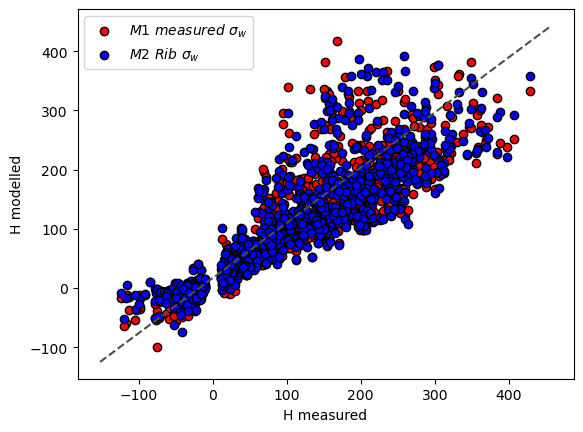

In [64]:
#final plot, checking in with the testing data

fig, ax = plt.subplots()

plt.scatter(sample_df_rest['H_10m'], sample_df_rest['H_10m_modeled'], color='red',edgecolor = 'black',label=r'$M1 \ measured \  \sigma_{w}$')
plt.scatter(sample_df_rest['H_10m'], sample_df_rest['alt_H_10m_modeled'], color='blue',edgecolor = 'black',label=r'$M2 \ Rib \ \sigma_{w}$')

plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3",label='_nolegend_')

ax.set_xlabel('H measured')
ax.set_ylabel('H modelled')
#plt.plot(sample_df_rest['H_10m_param'], intercept + gradient*sample_df_rest['H_10m_param'], 'blue')
#plt.text(6000, 100,f"{intercept:.3f} + {gradient:.3f}*x")
plt.legend()


